In [4]:
import torch
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

#model_repo = 'intfloat/e5-mistral-7b-instruct'
model_repo = "Salesforce/SFR-Embedding-Mistral"
tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = AutoModel.from_pretrained(model_repo, load_in_4bit=True)

model.eval()

tokenizer_config.json:   0%|          | 0.00/956 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

MistralModel(
  (embed_tokens): Embedding(32000, 4096, padding_idx=2)
  (layers): ModuleList(
    (0-31): 32 x MistralDecoderLayer(
      (self_attn): MistralSdpaAttention(
        (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): MistralRotaryEmbedding()
      )
      (mlp): MistralMLP(
        (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): MistralRMSNorm()
      (post_attention_layernorm): MistralRMSNorm()
    )
  )
  (norm): MistralRMSNorm()
)

In [5]:
# Each query must come with a one-sentence instruction that describes the task
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

task = 'Given a web search query, retrieve relevant passages that answer the query'
queries = [
    get_detailed_instruct(task, 'how much protein should a female eat'),
    get_detailed_instruct(task, 'summit define')
]
# No need to add instruction for retrieval documents
documents = [
    "As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
    "Definition of summit for English Language Learners. : 1  the highest point of a mountain : the top of a mountain. : 2  the highest level. : 3  a meeting or series of meetings between the leaders of two or more governments."
]

recipes = [
    """Ingredients: 1 lb shrimp, 2 cups bell peppers (sliced), 1 cup pineapple chunks, 1/4 cup teriyaki sauce, 2 tbsp olive oil, 2 cloves garlic (minced), 1 tsp chili flakes, 2 cups cooked quinoa.""",
    """Instructions: Sauté shrimp, peppers, and garlic in olive oil. Add pineapple, teriyaki sauce, chili flakes. Cook until shrimp are pink. Serve over quinoa. Enjoy!""",
    """Ingredients: 1 lb chicken breasts, 2 cups broccoli florets, 1 cup sliced carrots, 1/4 cup soy sauce, 2 tbsp sesame oil, 2 tbsp honey, 2 cloves garlic(minced), 1 tsp ginger (grated), 2 cups cooked rice. """,
    """Instructions: Cook chicken in sesame oil until brown. Add broccoli, carrots, garlic, and ginger. Mix soy sauce and honey, add to pan. Cook until veggies are tender. Serve over rice."""
]

math = ["""
\[
\begin{align*}
\text{Let } I &= \int_0^\infty e^{-x^2} dx. \\
\text{Consider } I^2 &= \left( \int_0^\infty e^{-x^2} dx \right)\left( \int_0^\infty e^{-y^2} dy \right) \\
&= \int_0^\infty \int_0^\infty e^{-x^2 - y^2} dx dy. \\
\text{Switch to polar coordinates: } \\
x^2 + y^2 &= r^2, \\
dx dy &= r dr d\theta, \\
\text{Bounds change to } 0 &\leq r < \infty, 0 \leq \theta \leq \frac{\pi}{2}. \\
\therefore I^2 &= \int_0^{\frac{\pi}{2}} \int_0^\infty e^{-r^2} r dr d\theta \\
&= \int_0^{\frac{\pi}{2}} d\theta \int_0^\infty e^{-r^2} r dr. \\
\text{Let } u &= r^2 \Rightarrow du = 2r dr. \\
\text{Thus, } \int_0^\infty e^{-r^2} r dr &= \frac{1}{2} \int_0^\infty e^{-u} du = \frac{1}{2}. \\
\therefore I^2 &= \frac{\pi}{2} \times \frac{1}{2} = \frac{\pi}{4}. \\
\text{Hence, } I &= \sqrt{\frac{\pi}{4}} = \frac{\sqrt{\pi}}{2}.
\end{align*}
\]
"""]
input_texts = queries + documents + recipes + math

with torch.no_grad():
    max_length = 4096
    # Tokenize the input texts
    batch_dict = tokenizer(input_texts, max_length=max_length - 1, return_attention_mask=False, padding=False, truncation=True)
    # append eos_token_id to every input_ids
    batch_dict['input_ids'] = [input_ids + [tokenizer.eos_token_id] for input_ids in batch_dict['input_ids']]
    batch_dict = tokenizer.pad(batch_dict, padding=True, return_attention_mask=True, return_tensors='pt')

    outputs = model(**batch_dict)
    embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

    # normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    scores = (embeddings @ embeddings.T) * 100
    print(scores.tolist())


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[[100.125, 39.5625, 83.0, 40.125, 47.6875, 44.375, 48.5625, 45.25, 40.8125], [39.5625, 100.0, 39.84375, 81.6875, 40.46875, 39.59375, 37.875, 37.5, 42.8125], [83.0, 39.84375, 100.0, 42.34375, 48.125, 44.125, 49.875, 46.34375, 38.75], [40.125, 81.6875, 42.34375, 100.0, 38.46875, 36.90625, 37.9375, 36.875, 43.25], [47.6875, 40.46875, 48.125, 38.46875, 99.9375, 94.6875, 74.5, 70.875, 41.75], [44.375, 39.59375, 44.125, 36.90625, 94.6875, 99.9375, 69.8125, 72.0, 42.90625], [48.5625, 37.875, 49.875, 37.9375, 74.5, 69.8125, 100.0, 92.4375, 39.53125], [45.25, 37.5, 46.34375, 36.875, 70.875, 72.0, 92.4375, 100.125, 39.9375], [40.8125, 42.8125, 38.75, 43.25, 41.75, 42.90625, 39.53125, 39.9375, 100.125]]


In [7]:
results_mistral_7b_embed = [[99.9375, 46.875, 83.8125, 46.71875, 54.15625, 50.375, 55.65625, 53.03125, 47.3125], [46.875, 100.125, 46.15625, 81.625, 46.15625, 45.15625, 44.625, 44.8125, 49.40625], [83.8125, 46.15625, 100.0, 48.375, 53.71875, 48.90625, 56.0, 53.0625, 44.34375], [46.71875, 81.625, 48.375, 100.0, 44.28125, 42.25, 44.71875, 44.0625, 49.03125], [54.15625, 46.15625, 53.71875, 44.28125, 99.9375, 93.9375, 79.125, 76.0, 49.0], [50.375, 45.15625, 48.90625, 42.25, 93.9375, 100.125, 73.75, 77.5, 50.71875], [55.65625, 44.625, 56.0, 44.71875, 79.125, 73.75, 99.9375, 92.6875, 47.5], [53.03125, 44.8125, 53.0625, 44.0625, 76.0, 77.5, 92.6875, 100.125, 49.15625], [47.3125, 49.40625, 44.34375, 49.03125, 49.0, 50.71875, 47.5, 49.15625, 100.0]]
print(results_mistral_7b_embed)

[[99.9375, 46.875, 83.8125, 46.71875, 54.15625, 50.375, 55.65625, 53.03125, 47.3125], [46.875, 100.125, 46.15625, 81.625, 46.15625, 45.15625, 44.625, 44.8125, 49.40625], [83.8125, 46.15625, 100.0, 48.375, 53.71875, 48.90625, 56.0, 53.0625, 44.34375], [46.71875, 81.625, 48.375, 100.0, 44.28125, 42.25, 44.71875, 44.0625, 49.03125], [54.15625, 46.15625, 53.71875, 44.28125, 99.9375, 93.9375, 79.125, 76.0, 49.0], [50.375, 45.15625, 48.90625, 42.25, 93.9375, 100.125, 73.75, 77.5, 50.71875], [55.65625, 44.625, 56.0, 44.71875, 79.125, 73.75, 99.9375, 92.6875, 47.5], [53.03125, 44.8125, 53.0625, 44.0625, 76.0, 77.5, 92.6875, 100.125, 49.15625], [47.3125, 49.40625, 44.34375, 49.03125, 49.0, 50.71875, 47.5, 49.15625, 100.0]]


<Axes: >

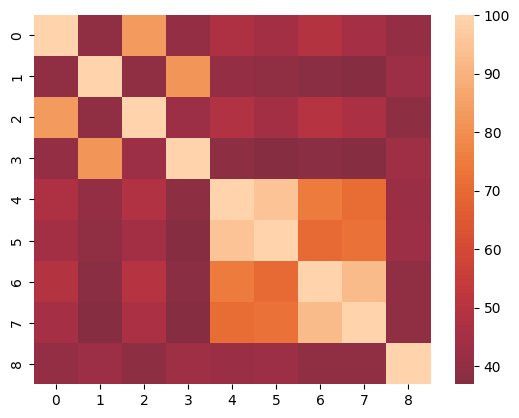

In [6]:
import seaborn as sns
sns.heatmap(scores.tolist(), center=0.0)